In [19]:
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
%matplotlib inline

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tqdm
import xarray as xr
import pandas as pd
import pycomlink.processing.wet_dry.cnn as cnn
import pycomlink.processing.wet_dry.mlp as mlp


import pycomlink as pycml

# Load and preprocess example data 

These steps are similar to the steps performed in the notebook "Basic CML processing workflow.ipynb". 

In [22]:
# Load data
data_path = pycml.io.examples.get_example_data_path()
cmls = xr.open_dataset(data_path + '/example_cml_data.nc')

# select 3 different CMLs to study
cmls = cmls.isel(cml_id = [0, 10, 370])

# Remove outliers, compute tl and interpolate missing values
cmls['tsl'] = cmls.tsl.where(cmls.tsl != 255.0)
cmls['rsl'] = cmls.rsl.where(cmls.rsl != -99.9)
cmls['tl'] = cmls.tsl - cmls.rsl # calculate total loss (previous TRSL)
cmls['tl'] = cmls.tl.interpolate_na(dim='time', method='linear', max_gap='5min')

# Do wet-dry classification using different methods and determine baseline

This compares 3 different ways of finding wet and dry periods in the CML time series. 

In [23]:
# wet dry detection using rsd
cmls['wet_rsd'] = cmls.tl.rolling(time=60, center=True).std() > 0.8

# wet dry detection using MLP
cmls['wet_mlp'] = (('cml_id', 'time'), np.zeros([cmls.cml_id.size, cmls.time.size]))
for cml_id in tqdm.tqdm(cmls.cml_id.values):
    mlp_out = mlp.mlp_wet_dry(
        trsl_channel_1 = cmls.sel(cml_id = cml_id).isel(channel_id = 0).tl.values,
        trsl_channel_2 = cmls.sel(cml_id = cml_id).isel(channel_id = 1).tl.values,
    )
    cmls['wet_mlp'].loc[{'cml_id':cml_id}]=  np.argmax(mlp_out, axis = 1)

# wet dry detection using CNN
cmls['wet_cnn'] = (('cml_id', 'time'), np.zeros([cmls.cml_id.size, cmls.time.size]))
for cml_id in tqdm.tqdm(cmls.cml_id.values):
    cnn_out = cnn.cnn_wet_dry(
        trsl_channel_1 = cmls.sel(cml_id = cml_id).isel(channel_id = 0).tl.values,
        trsl_channel_2 = cmls.sel(cml_id = cml_id).isel(channel_id = 1).tl.values,
    )
    cmls['wet_cnn'].loc[{'cml_id':cml_id}]=  cnn_out > 0.82

10
10


In [24]:
# Determine baseline for the 
cmls['baseline_rsd'] = pycml.processing.baseline.baseline_constant(trsl=cmls.tl, wet=cmls.wet_rsd, n_average_last_dry=5)
cmls['baseline_mlp'] = pycml.processing.baseline.baseline_constant(trsl=cmls.tl, wet=cmls.wet_mlp, n_average_last_dry=5)
cmls['baseline_cnn'] = pycml.processing.baseline.baseline_constant(trsl=cmls.tl, wet=cmls.wet_cnn, n_average_last_dry=5)


### Plot TL and baseline for good CML

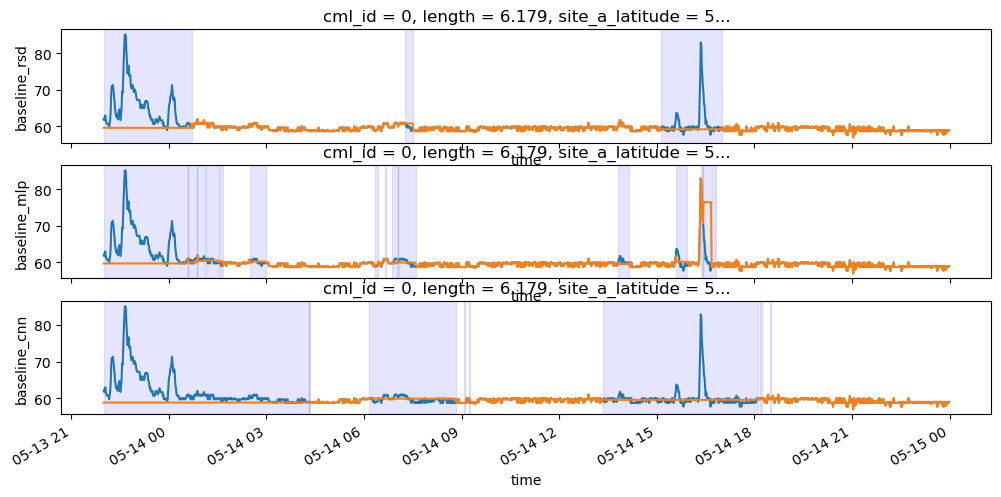

In [25]:
start = '2018-05-13T22'
end = '2018-05-14'
cml_plot = cmls.sel(time = slice(start, end)).isel(cml_id = 0, channel_id = 0)

# convert float to bool for plotting the shaded areas
cml_plot['wet_rsd'] = cml_plot.fillna(0).wet_rsd.astype(bool)
cml_plot['wet_mlp'] = cml_plot.fillna(0).wet_mlp.astype(bool)
cml_plot['wet_cnn'] = cml_plot.fillna(0).wet_cnn.astype(bool)


fig, axs = plt.subplots(3, 1, figsize=(12,5), sharex=True)
cml_plot.tl.plot.line(x='time', ax=axs[0]);
cml_plot.tl.plot.line(x='time', ax=axs[1]);
cml_plot.tl.plot.line(x='time', ax=axs[2]);

# shaded rsd
cml_plot['wet_rsd'][0] = 0 
cml_plot['wet_rsd'][-1] = 0 
wet_start = np.roll(cml_plot.wet_rsd, -1) & ~cml_plot.wet_rsd
wet_end = np.roll(cml_plot.wet_rsd, 1) & ~cml_plot.wet_rsd
for wet_start_i, wet_end_i in zip(
    wet_start.values.nonzero()[0],
    wet_end.values.nonzero()[0],
):
    axs[0].axvspan(cml_plot.time.values[wet_start_i], cml_plot.time.values[wet_end_i], color='b', alpha=0.1)

# shaded mlp
cml_plot['wet_mlp'][0] = 0 
cml_plot['wet_mlp'][-1] = 0 
wet_start = np.roll(cml_plot.wet_mlp, -1) & ~cml_plot.wet_mlp
wet_end = np.roll(cml_plot.wet_mlp, 1) & ~cml_plot.wet_mlp
for wet_start_i, wet_end_i in zip(
    wet_start.values.nonzero()[0],
    wet_end.values.nonzero()[0],
):
    axs[1].axvspan(cml_plot.time.values[wet_start_i], cml_plot.time.values[wet_end_i], color='b', alpha=0.1)

# shaded mlp
cml_plot['wet_cnn'][0] = 0 
cml_plot['wet_cnn'][-1] = 0 
wet_start = np.roll(cml_plot.wet_cnn, -1) & ~cml_plot.wet_cnn
wet_end = np.roll(cml_plot.wet_cnn, 1) & ~cml_plot.wet_cnn
for wet_start_i, wet_end_i in zip(
    wet_start.values.nonzero()[0],
    wet_end.values.nonzero()[0],
):
    axs[2].axvspan(cml_plot.time.values[wet_start_i], cml_plot.time.values[wet_end_i], color='b', alpha=0.1)

axs[0].set_title('');
axs[0].set_xlabel('')
axs[1].set_title('');
axs[1].set_xlabel('')
axs[2].set_title('');


cml_plot.baseline_rsd.plot.line(x='time', ax=axs[0], label ='baseline');
cml_plot.baseline_mlp.plot.line(x='time', ax=axs[1], label ='baseline');
cml_plot.baseline_cnn.plot.line(x='time', ax=axs[2], label ='baseline');


In [26]:
# Notes: 

# The MLP is able to identify two peaks at 16:00, but the higher resolution makes it miss the crusial first 
# timesteps in the second peak, resulting in a misplaced baseline. This can be fixed by adding for instance 
# 10 minutes of wet period before MLP wet period. 

# The CNN generally estimates longer periods of wet, this can be beneficial for getting a more stable 
# baseline, but a drawback if the singal is noisy as noise above the baseline can be interpreted as 
# rainfall later in the processing. 

# The RSD approach is more robust, but detects fewer of the lone events. 

### Plot TL and baseline for a less good CML

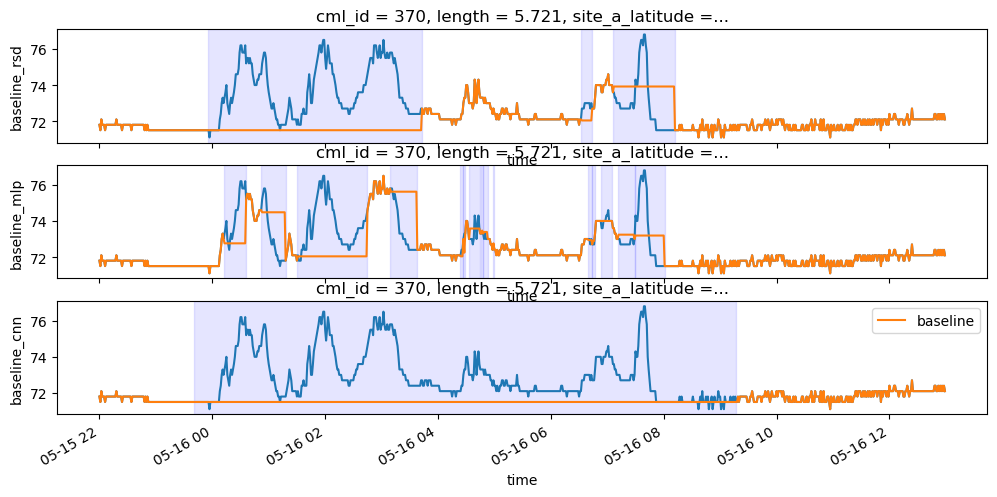

In [27]:
start = '2018-05-15T22'
end = '2018-05-16T12'
cml_plot = cmls.sel(time = slice(start, end)).isel(cml_id = 2, channel_id = 0)

# convert float to bool for plotting the shaded areas
cml_plot['wet_rsd'] = cml_plot.fillna(0).wet_rsd.astype(bool)
cml_plot['wet_mlp'] = cml_plot.fillna(0).wet_mlp.astype(bool)
cml_plot['wet_cnn'] = cml_plot.fillna(0).wet_cnn.astype(bool)

fig, axs = plt.subplots(3, 1, figsize=(12,5), sharex=True)
cml_plot.tl.plot.line(x='time', ax=axs[0]);
cml_plot.tl.plot.line(x='time', ax=axs[1]);
cml_plot.tl.plot.line(x='time', ax=axs[2]);

# shaded rsd
cml_plot['wet_rsd'][0] = 0 
cml_plot['wet_rsd'][-1] = 0 
wet_start = np.roll(cml_plot.wet_rsd, -1) & ~cml_plot.wet_rsd
wet_end = np.roll(cml_plot.wet_rsd, 1) & ~cml_plot.wet_rsd
for wet_start_i, wet_end_i in zip(
    wet_start.values.nonzero()[0],
    wet_end.values.nonzero()[0],
):
    axs[0].axvspan(cml_plot.time.values[wet_start_i], cml_plot.time.values[wet_end_i], color='b', alpha=0.1)

# shaded mlp
cml_plot['wet_mlp'][0] = 0 
cml_plot['wet_mlp'][-1] = 0 
wet_start = np.roll(cml_plot.wet_mlp, -1) & ~cml_plot.wet_mlp
wet_end = np.roll(cml_plot.wet_mlp, 1) & ~cml_plot.wet_mlp
for wet_start_i, wet_end_i in zip(
    wet_start.values.nonzero()[0],
    wet_end.values.nonzero()[0],
):
    axs[1].axvspan(cml_plot.time.values[wet_start_i], cml_plot.time.values[wet_end_i], color='b', alpha=0.1)

# shaded mlp
cml_plot['wet_cnn'][0] = 0 
cml_plot['wet_cnn'][-1] = 0 
wet_start = np.roll(cml_plot.wet_cnn, -1) & ~cml_plot.wet_cnn
wet_end = np.roll(cml_plot.wet_cnn, 1) & ~cml_plot.wet_cnn
for wet_start_i, wet_end_i in zip(
    wet_start.values.nonzero()[0],
    wet_end.values.nonzero()[0],
):
    axs[2].axvspan(cml_plot.time.values[wet_start_i], cml_plot.time.values[wet_end_i], color='b', alpha=0.1)

axs[0].set_title('');
axs[0].set_xlabel('')
axs[1].set_title('');
axs[1].set_xlabel('')
axs[2].set_title('');
cml_plot.baseline_rsd.plot.line(x='time', ax=axs[0], label ='baseline');
cml_plot.baseline_mlp.plot.line(x='time', ax=axs[1], label ='baseline');
cml_plot.baseline_cnn.plot.line(x='time', ax=axs[2], label ='baseline');
plt.legend()

In [ ]:
# Notes: 

# The MLP is detects several smaller rainfall events around 07:00, but the resulting baseline 
# does not look reasonable. At 03:00 the mlp seem to miss an important event. 

# The CNN generally estimates longer periods of wet. 

# The RSD method finds the two largest events, but seems to miss the rain in the middle. 